In [1]:
import torch
import torch.fft
from torch.fft import fftshift

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter

In [57]:
import cv2
from scipy import signal

In [3]:
pyr_path = '/pscratch/sd/c/cjacobus/Nyx_512/train_s1_512_real_flux.h5'
pyr = h5py.File(pyr_path, 'r')
ext = 128
#pyr_field = np.log(pyr[folder][field][:ext,:ext,:ext].astype(dtype))
#pyr_field = pyr[folder][field][:ext,:ext,:ext].astype(dtype)
pyr_field = pyr['fine'][0,:ext,:ext,:ext].astype(np.single)
#pyr_field = np.exp(10*(pyr_field+0.5))


torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])


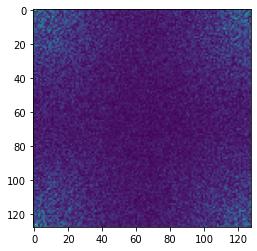

torch.Size([1, 128, 128, 128])


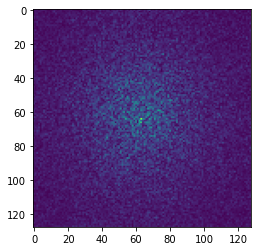

In [36]:
t = torch.from_numpy(pyr_field[None, :, :, :])
print(t.shape)
fft_t = torch.fft.fftn(t, norm='ortho', dim=(1,2,3))
print(fft_t.shape)
plt.imshow(abs(fft_t[0,:,:,32]))
plt.show()
fft_t_shift = torch.fft.fftshift(fft_t)
print(fft_t_shift.shape)
plt.imshow(abs(fft_t_shift[0,:,:,32]))
plt.show()

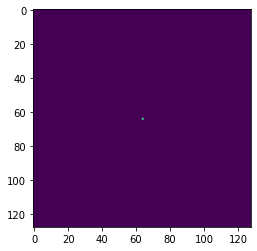

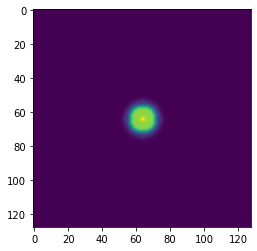

tensor([[ 1.2904e-15,  1.3215e-15,  1.3298e-15,  ..., -1.2669e-16,
         -3.9833e-18,  1.0744e-16],
        [ 8.9802e-16,  9.3267e-16,  9.6202e-16,  ..., -1.1379e-16,
          5.5705e-18,  1.3425e-16],
        [ 8.9597e-16,  9.0428e-16,  9.1244e-16,  ..., -6.2977e-17,
          1.2599e-16,  3.2047e-16],
        ...,
        [-8.8300e-17, -1.2387e-16, -1.0804e-16,  ..., -4.8393e-16,
         -4.7465e-16, -4.2052e-16],
        [-1.1404e-16, -1.8869e-16, -2.4125e-16,  ..., -1.3260e-16,
         -9.9115e-17, -1.5418e-17],
        [ 1.1340e-17, -4.9740e-17, -8.6786e-17,  ..., -8.4288e-17,
         -9.2850e-18,  7.8594e-17]], dtype=torch.float64)


In [101]:
arr = np.zeros((128, 128, 128))
rad = 32
cent = 64
for x in range(128):
    for y in range(128):
        for z in range(128):
            if ((x-cent)**2 + (y-cent)**2 + (z-cent)**2) <= rad**2:
                arr[x,y,z] = 1
                
mask = torch.from_numpy(arr[None, :, :, :])
plt.imshow(mask[0,32,:,:])
plt.show()

sigma = 1.0     # width of kernel
x = np.arange(-10,11,1)   # coordinate arrays -- make sure they contain 0!
y = np.arange(-10,11,1)
z = np.arange(-10,11,1)
xx, yy, zz = np.meshgrid(x,y,z)
kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))

kernel = kernel[ :, :, :]

# apply to sample data

blur_mask = signal.convolve(arr, kernel, mode="same")
blur_mask = torch.from_numpy(blur_mask[None, :, :, :])
plt.imshow(blur_mask[0,32,:,:])
plt.show()

print(blur_mask[0,32,:,:])

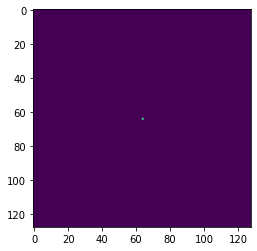

torch.Size([1, 128, 128, 128])


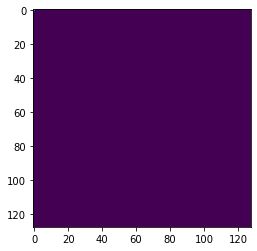

In [102]:

masked = torch.mul(fft_t_shift, mask) #fft_t_shift * mask
plt.imshow(abs(masked[0,:,:,32]))
plt.show()
masked_back = torch.fft.ifftshift(masked)
print(masked_back.shape)
plt.imshow(abs(masked_back[0,:,:,32]))
plt.show()


torch.Size([1, 128, 128, 128])


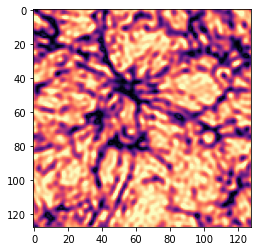

In [103]:
ifft_t = torch.fft.ifftn(masked_back, norm='ortho', dim=(1,2,3))
print(ifft_t.shape)
plt.imshow(abs(ifft_t[0,:,:,32]), cmap=cm.magma, vmin=0, vmax=1)
plt.show()

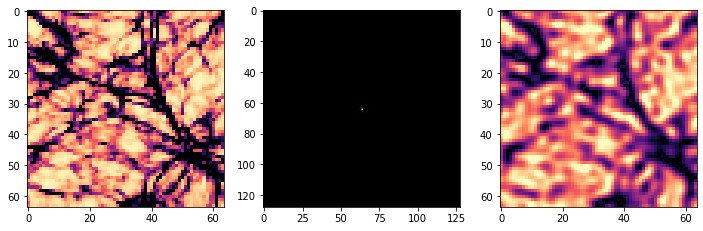

In [105]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1], height_ratios=[1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(pyr_field[:64,:64,32], cmap=cm.magma, vmin=0, vmax=1)#norm=thisNorm)

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(abs(masked[0,:,:,64]), cmap=cm.gray, )#norm=thisNorm)

ax2 = fig.add_subplot(gs[0, 2])
ax2.imshow(abs(ifft_t[0,:64,:64,32]), cmap=cm.magma, vmin=0, vmax=1)#norm=thisNorm)


In [106]:
print(abs(ifft_t[0,:64,:64,32]))

tensor([[0.2456, 0.0141, 0.0403,  ..., 0.8029, 0.6032, 0.5440],
        [0.3942, 0.1110, 0.0418,  ..., 0.5763, 0.3828, 0.3200],
        [0.6341, 0.4089, 0.2657,  ..., 0.3167, 0.1757, 0.1173],
        ...,
        [0.8785, 0.9589, 0.9859,  ..., 0.2378, 0.4242, 0.5659],
        [0.7374, 0.8647, 0.9395,  ..., 0.3566, 0.5970, 0.7217],
        [0.6325, 0.7745, 0.8730,  ..., 0.3976, 0.6709, 0.8338]],
       dtype=torch.float64)


[ 0.       0.31415  0.6283   0.94245  1.2566   1.57075  1.8849   2.19905
  2.5132   2.82735  3.1415   3.45565  3.7698   4.08395  4.3981   4.71225
  5.0264   5.34055  5.6547   5.96885  6.283    6.59715  6.9113   7.22545
  7.5396   7.85375  8.1679   8.48205  8.7962   9.11035  9.4245   9.73865
 10.0528  10.36695 10.6811  10.99525 11.3094  11.62355 11.9377  12.25185
 12.566   12.88015 13.1943  13.50845 13.8226  14.13675 14.4509  14.76505
 15.0792  15.39335 15.7075  16.02165 16.3358  16.64995 16.9641  17.27825
 17.5924  17.90655 18.2207  18.53485 18.849   19.16315 19.4773  19.79145
 20.1056 ]
[2.19703539e-34 2.99575827e-02 2.21020662e-02 2.14889799e-02
 1.71508907e-02 1.43829672e-02 1.21327969e-02 1.18231566e-02
 1.03673712e-02 9.07952317e-03 7.92499333e-03 6.69415107e-03
 5.79305608e-03 4.90763005e-03 4.13894020e-03 3.64617767e-03
 3.20069347e-03 2.66809383e-03 2.32189438e-03 1.90362697e-03
 1.53624850e-03 1.32818322e-03 1.14024650e-03 9.55640354e-04
 7.89089824e-04 6.11068365e-04 4.846680

(1e-07, 0.1)

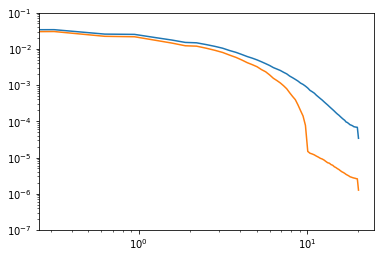

In [107]:
mean = np.mean(pyr_field)
over_or = (pyr_field-mean)/mean

out = abs(ifft_t[0,:,:,:]).numpy()
mean = np.mean(out)
over_out = (out-mean)/mean

f, Pxx_den = signal.periodogram(over_or, fs=512/80, scaling='spectrum', axis=-1) # spectrum || density
Pk = np.mean(Pxx_den, axis=(0,1))
f = f*2*3.1415

f2, Pxx_den2 = signal.periodogram(over_out, fs=512/80, scaling='spectrum', axis=-1) # spectrum || density
Pk2 = np.mean(Pxx_den2, axis=(0,1))
f2 = f2*2*3.1415

print(f2)
print(Pk2)

plt.plot(f,Pk)
plt.plot(f2,Pk2)
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.0000001, 0.1])

In [4]:
hist, bins = torch.histogram(pyr_field, bins=20, density=true)

AttributeError: module 'torch' has no attribute 'histogram'

In [6]:
import torch.histc

ModuleNotFoundError: No module named 'torch.histc'